In [4]:
import pandas as pd # type: ignore
# 显示所有列
pd.set_option('display.max_columns', None)
# # 显示所有行
pd.set_option('display.max_rows', None) 
# 所有列并排展开
pd.set_option('display.width', 1000)

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None) 

# 1. 加载数据
df = pd.read_csv('..\Data\data1.csv')  # 请确保文件路径正确

# 2. 数据预处理
X = df.drop('Y(1=default, 0=non-default)', axis=1)  # 假设'Target'是目标变量
y = df['Y(1=default, 0=non-default)']

# 3. 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. 应用PCA
pca = PCA(n_components=0.95)  # 保留95%的方差
X_pca = pca.fit_transform(X_scaled)

# 5. 应用Lasso回归
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

lasso = Lasso(alpha=0.1)  # alpha参数可以调整
lasso.fit(X_train, y_train)

# 6. 获取特征重要性
feature_importance = np.abs(lasso.coef_)

# 7. 选择重要特征
threshold = np.percentile(feature_importance, 75)  # 选择前25%的特征
selected_features = feature_importance >= threshold

# 8. 获取原始特征的重要性
original_feature_importance = pca.components_.T.dot(lasso.coef_)
original_feature_importance = np.abs(original_feature_importance)

# 9. 选择原始特征
original_selected_features = original_feature_importance >= np.percentile(original_feature_importance, 75)

# 10. 打印结果
print("Selected PCA components:", np.sum(selected_features))
print("Selected original features:", np.sum(original_selected_features))
print("Selected original feature indices:", np.where(original_selected_features)[0])

# 11. 获取选择的原始特征名称
selected_feature_names = X.columns[original_selected_features].tolist()
print("Selected original feature names:", selected_feature_names)

# 12. 创建特征重要性的DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': original_feature_importance
})

# 13. 按重要性降序排序
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# 14. 保存为CSV文件
feature_importance_df.to_csv('..\Data\Q1_feature_importance.csv', index=False)

print("\nFeature importance scores have been saved to '..\Data\feature_importance.csv'")

# 15. 打印特征重要性分数
print("\nFeature importance scores:")
for _, row in feature_importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']}")

Selected PCA components: 20
Selected original features: 6
Selected original feature indices: [ 0  2  4 15 19 20]
Selected original feature names: ['X1', 'X3', 'X5', 'X16', 'X20', 'X21']

Feature importance scores have been saved to '..\Dataeature_importance.csv'

Feature importance scores:
X1: 0.02718462602328782
X3: 0.020419412201712152
X21: 0.01939808690599446
X20: 0.0173254239212852
X5: 0.017294136297608828
X16: 0.01357657115117055
X17: 0.013571725625836764
X12: 0.011420923228799383
X6: 0.010973911885589509
X10: 0.00890942129488548
X9: 0.008108653283630451
X14: 0.007770070325845331
X23: 0.006922294043443113
X18: 0.0068004705855411254
X22: 0.006491305550669588
X24: 0.006394005777539961
X7: 0.005886559226385307
X11: 0.005876256777551495
X19: 0.0050482214809149575
X15: 0.0036993312615741644
X2: 0.0029830132242438427
X8: 0.001856339521555206
X13: 0.0007539494863826853
X4: 0.00023136896825465486


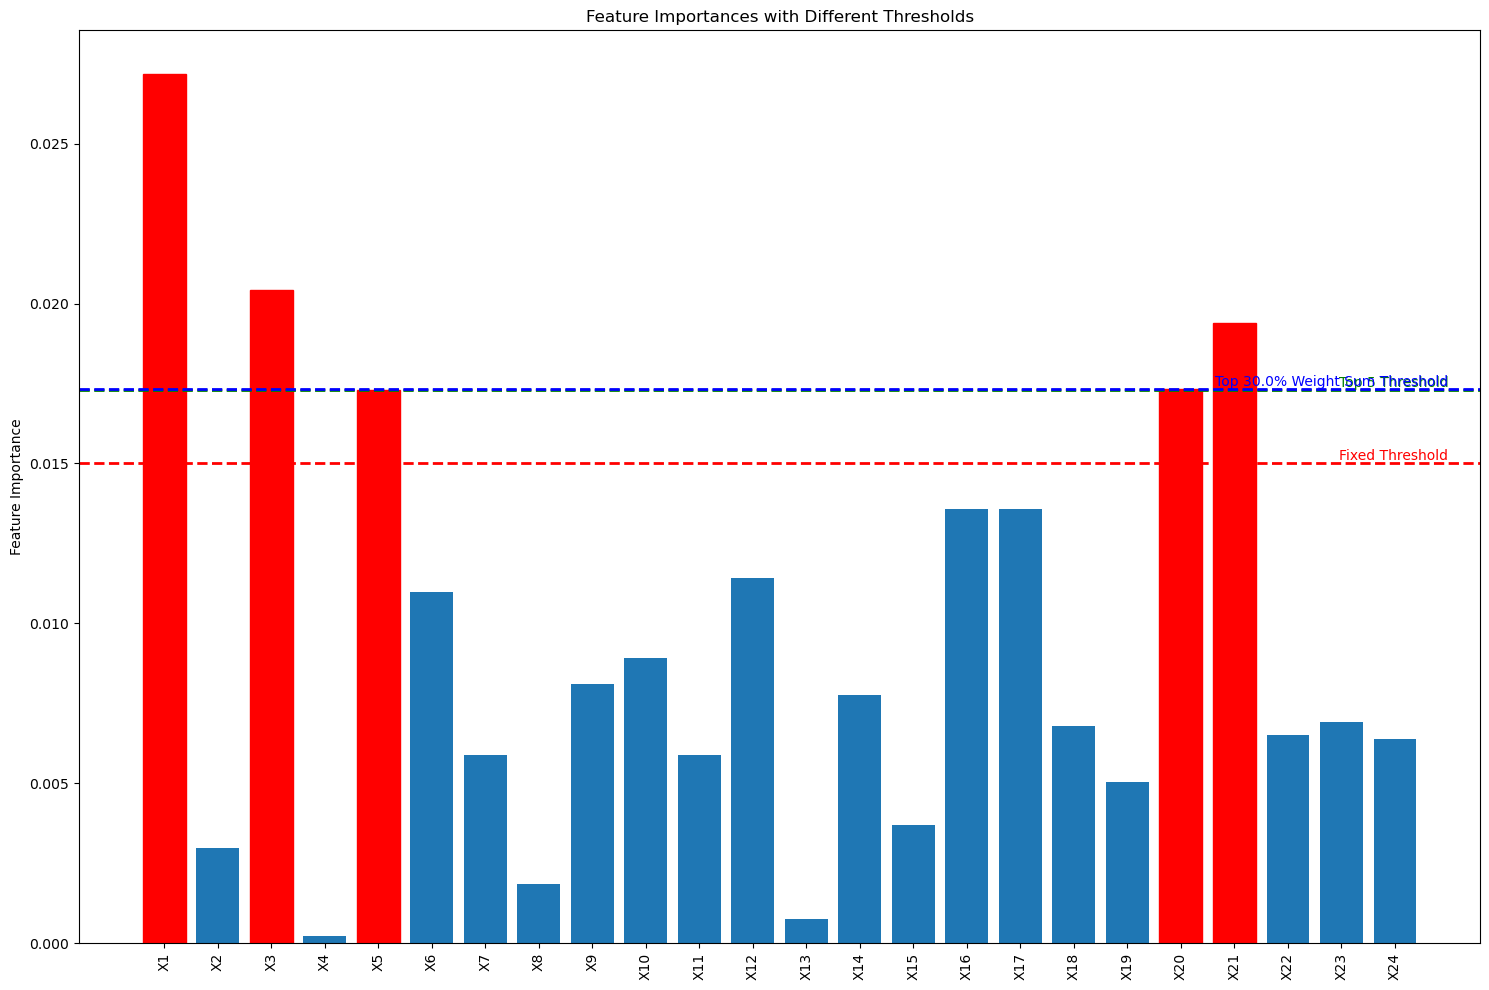

In [6]:
import matplotlib.pyplot as plt

# 1. 人为设定的阈值
fixed_threshold = 0.015

# 2. 筛选出重要性前k=5个指标的阈值
k = 5
top_k_threshold = np.sort(original_feature_importance)[-k]

# 3. 筛选出重要性权重之和前n=0.3的阈值
n = 0.3
sorted_importance = np.sort(original_feature_importance)[::-1]
cumsum_importance = np.cumsum(sorted_importance)
n_threshold = sorted_importance[np.where(cumsum_importance >= n * sum(original_feature_importance))[0][0]]

# 绘制条形图
plt.figure(figsize=(15, 10))
indices = np.arange(len(original_feature_importance))
bars = plt.bar(indices, original_feature_importance, align='center')

# 添加特征名称和重要性分数
plt.xticks(indices, X.columns, rotation='vertical')
plt.ylabel('Feature Importance')
plt.title('Feature Importances with Different Thresholds')

# 显示三种不同的阈值
plt.axhline(y=fixed_threshold, color='r', linestyle='--', linewidth=2)
plt.text(len(indices), fixed_threshold, 'Fixed Threshold', color='red', va='bottom', ha='right')

plt.axhline(y=top_k_threshold, color='g', linestyle='--', linewidth=2)
plt.text(len(indices), top_k_threshold, f'Top {k} Threshold', color='green', va='bottom', ha='right')

plt.axhline(y=n_threshold, color='b', linestyle='--', linewidth=2)
plt.text(len(indices), n_threshold, f'Top {n:.1%} Weight Sum Threshold', color='blue', va='bottom', ha='right')

# 为不同阈值下的特征设置不同颜色
for i, bar in enumerate(bars):
    if original_feature_importance[i] >= fixed_threshold:
        bar.set_color('red')
    elif original_feature_importance[i] >= top_k_threshold:
        bar.set_color('green')
    elif original_feature_importance[i] >= n_threshold:
        bar.set_color('blue')

plt.savefig('../Data/Q1_feature_importance_with_thresholds.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()